# Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:
 В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
 Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
 Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np

import requests
from urllib.parse import urlencode
import scipy.stats as ss
from scipy.stats import norm
from scipy.stats import levene
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu, ttest_ind, shapiro, levene, chi2_contingency
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

import re

from datetime import datetime

%matplotlib inline


## Задание 1
 Retention – один из самых важных показателей в компании. Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

### Выгрузка данных
Так как данные лежат в папке shared, выгружаем их оттуда.

In [2]:
df_reg = pd.read_csv ('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-dona/shared/problem1-reg_data.csv', sep = ';')
df_reg.head(3)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3


In [3]:
df_auth = pd.read_csv ('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-dona/shared/problem1-auth_data.csv', sep = ';')
df_auth.head(3)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2


### Предварительный анализ данных 
Нужно удостовериться, что с данными все в порядке. Посмотрим, есть ли пропущенные значения, дубликаты и т.д. Пройдемся по каждому файлу.

**df_reg**

In [4]:
df_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [5]:
df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [6]:
#Проверим, есть ли в данных пользователей, зарегистрировавшихся несколько раз
df_reg.duplicated(subset=['uid']).sum()

0

In [7]:
df_reg.uid.value_counts()

2047      1
506274    1
502176    1
414111    1
416158    1
         ..
427642    1
431736    1
454263    1
452214    1
2049      1
Name: uid, Length: 1000000, dtype: int64

In [8]:
df_reg.shape

(1000000, 2)

In [9]:
df_reg.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

**df_auth**

In [10]:
df_auth.dtypes

auth_ts    int64
uid        int64
dtype: object

In [11]:
df_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [12]:
#Проверим, есть ли в данных пользователей, авторизировавшихся несколько раз 
df_auth.duplicated(subset=['uid']).sum()

8601013

что является логичным, когда пользователи авторизуются несколько раз.
Посмотрим на авторизацию каждого пользователя.

In [13]:
df_auth.uid.value_counts()

2         1929
108       1397
158       1367
176       1331
191       1296
          ... 
78835        1
119791       1
21471        1
13267        1
8196         1
Name: uid, Length: 1000000, dtype: int64

In [14]:
df_auth.shape

(9601013, 2)

In [15]:
df_auth.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

В данных нет пропущенных значений, формат данных соответствует нужному типу, отсутствуют дубликаты регистарации пользователей. Каждый пользователь авторизовался как минимум один раз. Уникальных пользователей в каждом датасете одинкаковое количество (1 млн.).
Можно работать с данными. Начнем с переформатирования даты в обоих датасетах.

In [16]:
# Сделаем формат - дата.
df_reg ['reg_ts'] = pd.to_datetime(pd.to_datetime(df_reg ['reg_ts'], unit='s').dt.date)
df_reg

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5
...,...,...
999995,2020-09-23,1110618
999996,2020-09-23,1110619
999997,2020-09-23,1110620
999998,2020-09-23,1110621


In [17]:
df_auth['auth_ts'] =  pd.to_datetime(pd.to_datetime(df_auth['auth_ts'], unit='s').dt.date)
df_auth

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2
...,...,...
9601008,2020-09-23,1110618
9601009,2020-09-23,1110619
9601010,2020-09-23,1110620
9601011,2020-09-23,1110621


In [20]:
df_auth.auth_ts.min()

Timestamp('1998-11-18 00:00:00')

In [21]:
df_auth.auth_ts.max()

Timestamp('2020-09-23 00:00:00')

In [22]:
df_reg.reg_ts.min()

Timestamp('1998-11-18 00:00:00')

In [23]:
df_reg.reg_ts.max()

Timestamp('2020-09-23 00:00:00')

Датасеты с регистрацией и авторизацией имеют одинаковую вилку дат 18.11.1998-23.09.2020.

### Проведем когортный анализ

In [18]:
#Соединим два датафрейма в один, используя outer join,  чтобы включить всех пользователей из обеих таблиц. 
df_merged = df_auth.merge(df_reg, how='outer', on='uid')
df_merged

,auth_ts,uid,reg_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22
...,...,...,...
9601008,2020-09-23,1110618,2020-09-23
9601009,2020-09-23,1110619,2020-09-23
9601010,2020-09-23,1110620,2020-09-23
9601011,2020-09-23,1110621,2020-09-23


In [19]:
# Проверка на аномалии
df_merged.query("reg_ts > auth_ts")

,auth_ts,uid,reg_ts


In [20]:
# Проверка уникальности пользователей
df_merged.uid.nunique()

1000000

In [21]:
#Посчитаем для каждого факта авторизации количество дней от регистрации
df_merged ['delta'] = df_merged ['auth_ts'] - df_merged ['reg_ts']

In [22]:
df_merged.dtypes

auth_ts     datetime64[ns]
uid                  int64
reg_ts      datetime64[ns]
delta      timedelta64[ns]
dtype: object

In [23]:
#Поменяем тип данных стобца days для последующего удобства
df_merged ['delta'] = df_merged['delta'].dt.days
df_merged.dtypes

auth_ts    datetime64[ns]
uid                 int64
reg_ts     datetime64[ns]
delta               int64
dtype: object

In [24]:
# Посмотрим на количество пользователей в разрезе delta
df_merged.delta.value_counts()

0       1000000
6         68194
5         59863
7         58140
4         52258
         ...   
5587          1
5584          1
5590          1
5588          1
7729          1
Name: delta, Length: 5916, dtype: int64

In [25]:
# Так как датасет достаточно громоздкий, выберем тестовую выборку, на ней подсчитаем ретеншн, а потом 
# сделаем функцию. Для теста берем факт регистрации пользователей в последнем месяце - сентябре 2020 года
test_df = df_merged[(df_merged['reg_ts'].dt.year == 2020) & (df_merged['reg_ts'].dt.month == 9)]
test_df

,auth_ts,uid,reg_ts,delta
9545203,2020-09-01,1070035,2020-09-01,0
9545204,2020-09-02,1070035,2020-09-01,1
9545205,2020-09-09,1070035,2020-09-01,8
9545206,2020-09-10,1070035,2020-09-01,9
9545207,2020-09-14,1070035,2020-09-01,13
...,...,...,...,...
9601008,2020-09-23,1110618,2020-09-23,0
9601009,2020-09-23,1110619,2020-09-23,0
9601010,2020-09-23,1110620,2020-09-23,0
9601011,2020-09-23,1110621,2020-09-23,0


In [27]:
# Произведем группировку авторизовавшихся пользователей по дате регистрации и дельте
df_group= test_df.groupby(['reg_ts', 'delta'], as_index=False)\
                 .agg({'uid' : 'nunique'})\
                 .rename(columns = {'uid' : 'count'})
df_group

,reg_ts,delta,count
0,2020-09-01,0,1586
1,2020-09-01,1,32
2,2020-09-01,2,65
3,2020-09-01,3,67
4,2020-09-01,4,73
...,...,...,...
271,2020-09-21,1,31
272,2020-09-21,2,49
273,2020-09-22,0,1641
274,2020-09-22,1,14


In [28]:
# Создадим сводную таблицу
df_pivot = df_group.pivot_table(index='reg_ts', columns='delta', values='count')
df_pivot

delta,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-09-01,1586.0,32.0,65.0,67.0,73.0,102.0,89.0,102.0,65.0,86.0,...,87.0,68.0,70.0,69.0,80.0,66.0,69.0,57.0,69.0,25.0
2020-09-02,1588.0,40.0,62.0,74.0,90.0,99.0,113.0,100.0,77.0,65.0,...,69.0,79.0,84.0,66.0,77.0,62.0,59.0,74.0,42.0,NaN
2020-09-03,1591.0,37.0,86.0,75.0,104.0,111.0,136.0,101.0,87.0,100.0,...,95.0,87.0,85.0,70.0,77.0,74.0,87.0,38.0,NaN,NaN
2020-09-04,1593.0,32.0,58.0,58.0,82.0,102.0,116.0,79.0,85.0,69.0,...,89.0,70.0,72.0,72.0,68.0,76.0,42.0,NaN,NaN,NaN
2020-09-05,1596.0,44.0,63.0,74.0,87.0,94.0,119.0,78.0,81.0,87.0,...,86.0,72.0,82.0,71.0,76.0,40.0,NaN,NaN,NaN,NaN
2020-09-06,1599.0,50.0,69.0,87.0,90.0,94.0,109.0,97.0,93.0,88.0,...,83.0,88.0,73.0,77.0,41.0,NaN,NaN,NaN,NaN,NaN
2020-09-07,1601.0,47.0,68.0,86.0,81.0,102.0,117.0,84.0,66.0,90.0,...,81.0,68.0,81.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-08,1604.0,28.0,63.0,63.0,78.0,122.0,121.0,106.0,83.0,83.0,...,83.0,76.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-09,1607.0,28.0,52.0,75.0,92.0,107.0,92.0,95.0,70.0,81.0,...,78.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Поделим поколоночно значения в таблицена значения первой колонки. 
user_retention = df_pivot.divide(df_pivot[0], axis=0).round(4)
user_retention

delta,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-09-01,1.0,0.0202,0.0410,0.0422,0.0460,0.0643,0.0561,0.0643,0.0410,0.0542,...,0.0549,0.0429,0.0441,0.0435,0.0504,0.0416,0.0435,0.0359,0.0435,0.0158
2020-09-02,1.0,0.0252,0.0390,0.0466,0.0567,0.0623,0.0712,0.0630,0.0485,0.0409,...,0.0435,0.0497,0.0529,0.0416,0.0485,0.0390,0.0372,0.0466,0.0264,NaN
2020-09-03,1.0,0.0233,0.0541,0.0471,0.0654,0.0698,0.0855,0.0635,0.0547,0.0629,...,0.0597,0.0547,0.0534,0.0440,0.0484,0.0465,0.0547,0.0239,NaN,NaN
2020-09-04,1.0,0.0201,0.0364,0.0364,0.0515,0.0640,0.0728,0.0496,0.0534,0.0433,...,0.0559,0.0439,0.0452,0.0452,0.0427,0.0477,0.0264,NaN,NaN,NaN
2020-09-05,1.0,0.0276,0.0395,0.0464,0.0545,0.0589,0.0746,0.0489,0.0508,0.0545,...,0.0539,0.0451,0.0514,0.0445,0.0476,0.0251,NaN,NaN,NaN,NaN
2020-09-06,1.0,0.0313,0.0432,0.0544,0.0563,0.0588,0.0682,0.0607,0.0582,0.0550,...,0.0519,0.0550,0.0457,0.0482,0.0256,NaN,NaN,NaN,NaN,NaN
2020-09-07,1.0,0.0294,0.0425,0.0537,0.0506,0.0637,0.0731,0.0525,0.0412,0.0562,...,0.0506,0.0425,0.0506,0.0337,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-08,1.0,0.0175,0.0393,0.0393,0.0486,0.0761,0.0754,0.0661,0.0517,0.0517,...,0.0517,0.0474,0.0305,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-09,1.0,0.0174,0.0324,0.0467,0.0572,0.0666,0.0572,0.0591,0.0436,0.0504,...,0.0485,0.0243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# исключаем 0 день
user_retention = user_retention.iloc[:, 1:]
user_retention

delta,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-09-01,0.0202,0.0410,0.0422,0.0460,0.0643,0.0561,0.0643,0.0410,0.0542,0.0511,...,0.0549,0.0429,0.0441,0.0435,0.0504,0.0416,0.0435,0.0359,0.0435,0.0158
2020-09-02,0.0252,0.0390,0.0466,0.0567,0.0623,0.0712,0.0630,0.0485,0.0409,0.0567,...,0.0435,0.0497,0.0529,0.0416,0.0485,0.0390,0.0372,0.0466,0.0264,NaN
2020-09-03,0.0233,0.0541,0.0471,0.0654,0.0698,0.0855,0.0635,0.0547,0.0629,0.0635,...,0.0597,0.0547,0.0534,0.0440,0.0484,0.0465,0.0547,0.0239,NaN,NaN
2020-09-04,0.0201,0.0364,0.0364,0.0515,0.0640,0.0728,0.0496,0.0534,0.0433,0.0565,...,0.0559,0.0439,0.0452,0.0452,0.0427,0.0477,0.0264,NaN,NaN,NaN
2020-09-05,0.0276,0.0395,0.0464,0.0545,0.0589,0.0746,0.0489,0.0508,0.0545,0.0602,...,0.0539,0.0451,0.0514,0.0445,0.0476,0.0251,NaN,NaN,NaN,NaN
2020-09-06,0.0313,0.0432,0.0544,0.0563,0.0588,0.0682,0.0607,0.0582,0.0550,0.0488,...,0.0519,0.0550,0.0457,0.0482,0.0256,NaN,NaN,NaN,NaN,NaN
2020-09-07,0.0294,0.0425,0.0537,0.0506,0.0637,0.0731,0.0525,0.0412,0.0562,0.0600,...,0.0506,0.0425,0.0506,0.0337,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-08,0.0175,0.0393,0.0393,0.0486,0.0761,0.0754,0.0661,0.0517,0.0517,0.0655,...,0.0517,0.0474,0.0305,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-09,0.0174,0.0324,0.0467,0.0572,0.0666,0.0572,0.0591,0.0436,0.0504,0.0373,...,0.0485,0.0243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Визуализируем данные
ur_style = (user_retention
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep="")  # числа форматируем как проценты, NaN заменяем на пустоту
            .set_table_styles([{
                'selector': 'td',
                'props': [('font-size', '10px')]
            }])
            .set_table_attributes('title="User retention by cohort"')  # подпись оси X
            .set_table_attributes('title="Retention Rate"')  # подпись оси Y
            )

ur_style

delta,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
reg_ts,,,,,,,,,,,,,,,,,,,,,,
2020-09-01 00:00:00,2.02%,4.10%,4.22%,4.60%,6.43%,5.61%,6.43%,4.10%,5.42%,5.11%,5.36%,4.85%,5.49%,4.29%,4.41%,4.35%,5.04%,4.16%,4.35%,3.59%,4.35%,1.58%
2020-09-02 00:00:00,2.52%,3.90%,4.66%,5.67%,6.23%,7.12%,6.30%,4.85%,4.09%,5.67%,5.48%,5.48%,4.35%,4.97%,5.29%,4.16%,4.85%,3.90%,3.72%,4.66%,2.64%,
2020-09-03 00:00:00,2.33%,5.41%,4.71%,6.54%,6.98%,8.55%,6.35%,5.47%,6.29%,6.35%,5.53%,5.85%,5.97%,5.47%,5.34%,4.40%,4.84%,4.65%,5.47%,2.39%,,
2020-09-04 00:00:00,2.01%,3.64%,3.64%,5.15%,6.40%,7.28%,4.96%,5.34%,4.33%,5.65%,5.52%,4.33%,5.59%,4.39%,4.52%,4.52%,4.27%,4.77%,2.64%,,,
2020-09-05 00:00:00,2.76%,3.95%,4.64%,5.45%,5.89%,7.46%,4.89%,5.08%,5.45%,6.02%,5.20%,4.57%,5.39%,4.51%,5.14%,4.45%,4.76%,2.51%,,,,
2020-09-06 00:00:00,3.13%,4.32%,5.44%,5.63%,5.88%,6.82%,6.07%,5.82%,5.50%,4.88%,4.75%,5.38%,5.19%,5.50%,4.57%,4.82%,2.56%,,,,,
2020-09-07 00:00:00,2.94%,4.25%,5.37%,5.06%,6.37%,7.31%,5.25%,4.12%,5.62%,6.00%,5.68%,4.56%,5.06%,4.25%,5.06%,3.37%,,,,,,
2020-09-08 00:00:00,1.75%,3.93%,3.93%,4.86%,7.61%,7.54%,6.61%,5.17%,5.17%,6.55%,5.36%,5.92%,5.17%,4.74%,3.05%,,,,,,,
2020-09-09 00:00:00,1.74%,3.24%,4.67%,5.72%,6.66%,5.72%,5.91%,4.36%,5.04%,3.73%,5.04%,4.79%,4.85%,2.43%,,,,,,,,


### Создаем функцию
На вход: 2 датасета, дата старта, от которой будет начинаться расчет, и конечная дата. 

Выход: Датасет с ретеншн.

In [38]:
def retention_rate(df_auth, df_reg, start_date, end_date):
    
    # Выгружаем данные о регистрации и авторизации по пути.
    df_reg = pd.read_csv(path_reg, sep=';') 
    df_auth = pd.read_csv(path_auth, sep=';')

    # Сделаем формат столбцов в таблице форматом дата.
    df_reg ['reg_ts'] = pd.to_datetime(pd.to_datetime(df_reg ['reg_ts'], unit='s').dt.date)
    df_auth['auth_ts'] =  pd.to_datetime(pd.to_datetime(df_auth['auth_ts'], unit='s').dt.date)
    
    #Соединим два датафрейма в один, используя outer join. 
    df_merged = df_auth.merge(df_reg, how='outer', on='uid')
    
    # выбираем только указанные даты
    df_merged = df_merged[(df_merged.reg_ts >= start_date) & (df_merged.auth_ts <= end_date)]
    
    #Посчитаем для каждого факта авторизации количество дней от регистрации
    df_merged ['delta'] = df_merged ['auth_ts'] - df_merged ['reg_ts']
    
    #Поменяем тип данных стобца days для последующего удобства
    df_merged ['delta'] = df_merged['delta'].dt.days
    
    # Произведем группировку авторизовавшихся пользователей по дате регистрации и дельте
    df_group= df_merged.groupby(['reg_ts', 'delta'], as_index=False)\
                     .agg({'uid' : 'nunique'})\
                     .rename(columns = {'uid' : 'count'})
    
    # Создадим сводную таблицу
    df_pivot = df_group.pivot_table(index='reg_ts', columns='delta', values='count')

    # Поделим поколоночно значения в таблицена значения первой колонки. 
    user_retention = df_pivot.divide(df_pivot[0], axis=0).round(4)
    
    # исключаем 0 день
    user_retention = user_retention.iloc[:, 1:]

    # Визуализируем данные

    sns.set()
    plt.figure(figsize=(20, 15))
    plt.title('User retention by cohort', size=20)
    ax = sns.heatmap(data=user_retention, cmap='viridis', annot=True, vmin=0, vmax=0.1, fmt='.2%', linewidths=1)
    ax.set_yticklabels(user_retention.index.strftime('%Y-%m-%d'))
    ax.set_xticklabels(user_retention.columns)
    plt.xlabel('Days after registration', fontsize=15)
    plt.ylabel('Date of registration', fontsize=15)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    ax.xaxis.set_ticks_position('top')

    plt.show()
    
    return user_retention

In [39]:
path_reg = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-dona/shared/problem1-reg_data.csv'
path_auth = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-dona/shared/problem1-auth_data.csv'

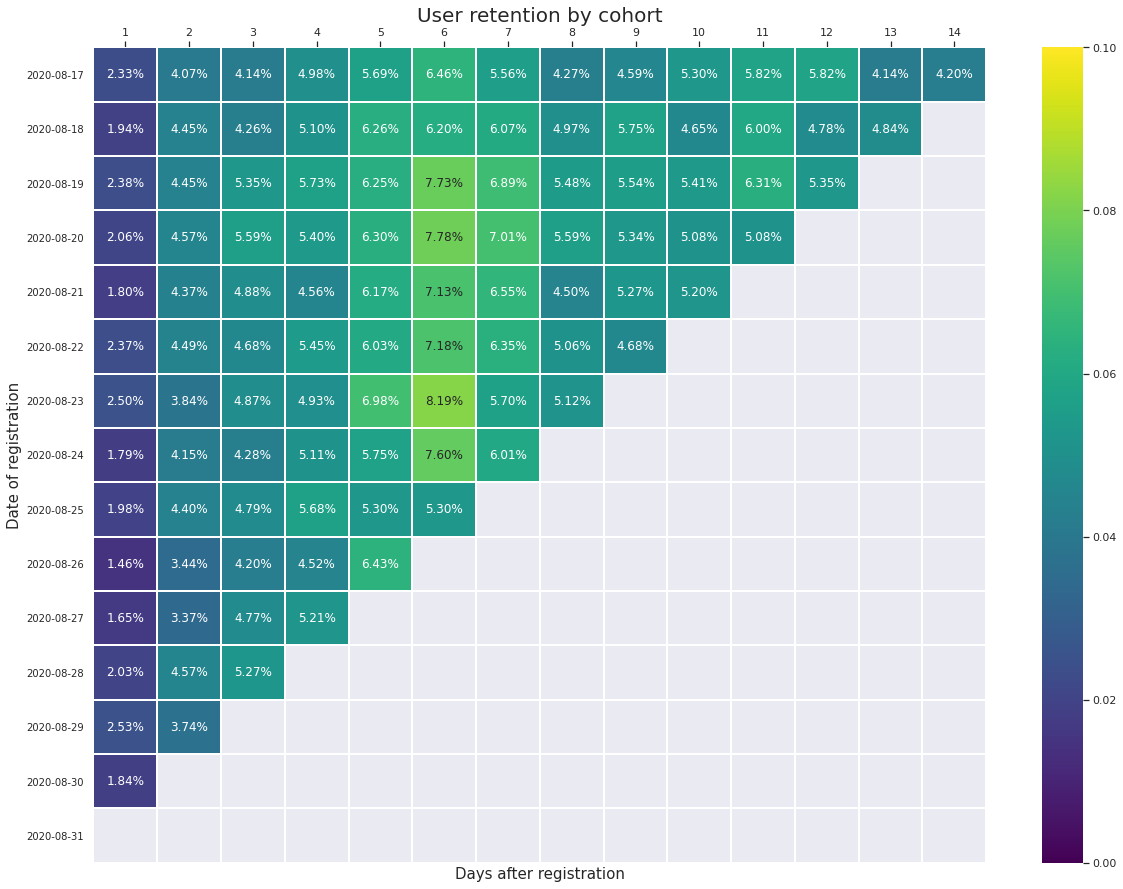

delta,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_ts,,,,,,,,,,,,,,
2020-08-17,0.0233,0.0407,0.0414,0.0498,0.0569,0.0646,0.0556,0.0427,0.0459,0.0530,0.0582,0.0582,0.0414,0.042
2020-08-18,0.0194,0.0445,0.0426,0.0510,0.0626,0.0620,0.0607,0.0497,0.0575,0.0465,0.0600,0.0478,0.0484,NaN
2020-08-19,0.0238,0.0445,0.0535,0.0573,0.0625,0.0773,0.0689,0.0548,0.0554,0.0541,0.0631,0.0535,NaN,NaN
2020-08-20,0.0206,0.0457,0.0559,0.0540,0.0630,0.0778,0.0701,0.0559,0.0534,0.0508,0.0508,NaN,NaN,NaN
2020-08-21,0.0180,0.0437,0.0488,0.0456,0.0617,0.0713,0.0655,0.0450,0.0527,0.0520,NaN,NaN,NaN,NaN
2020-08-22,0.0237,0.0449,0.0468,0.0545,0.0603,0.0718,0.0635,0.0506,0.0468,NaN,NaN,NaN,NaN,NaN
2020-08-23,0.0250,0.0384,0.0487,0.0493,0.0698,0.0819,0.0570,0.0512,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-24,0.0179,0.0415,0.0428,0.0511,0.0575,0.0760,0.0601,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-25,0.0198,0.0440,0.0479,0.0568,0.0530,0.0530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Попробуем работу функции, взяв две предпоследние недели августа 2020 
retention_rate(df_auth, df_reg, '2020-08-17','2020-08-31')

#### Таким образом, мы получили функцию, которая предназначена для анализа удержания пользователей по когортам. Когорты мы сформировали по дате регистрации. Функция позволяет анализировать и визуализировать, как долго пользователи остаются активными после регистрации.

#### Если посмотреть на тестовый запуск функции для анализа двух последних недель август, то можно сказать, что на 6-й день после регистрации происходит пик удержания, и хорошо бы узнать, что такого произошло в этот день, что поспособствовало удержанию пользователей.

#### П.С.Мы специально вынесли за пределы функции пути к файлам,чтобы в случае необходимости мы могли их легко изменить без  изменения кода функции. Это делает нашу функцию более гибкой.


## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?


### Выгрузка данных
Так как данные находятся на ЯндексДиск, то с помощью соответствующих библиотек получим ссылку на скачивание файла и преобразуем данные в датасет.

In [41]:
# Создаем базовый URL
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

In [42]:
# Создаем частный URL ссылки с платформы LMS
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

In [43]:
# Соединяем две части
final_url = base_url + urlencode(dict(public_key=public_key))

In [44]:
# Создаем ссылку для скачивания файла
response = requests.get(final_url)
download_url = response.json()['href']

In [45]:
# Считываем данные и преобразуем в датасет
df = pd.read_csv(download_url,  sep=';')
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


### Предварительный анализ данных
Нужно удостовериться, что с данными все в порядке. Посмотрим, есть ли пропущенные значения, дубликаты и т.д. 

In [46]:
# Проверим, есть ли пропущенные значения
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [47]:
# Проверим тип данных
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [48]:
df.duplicated(subset=['user_id']).sum()

0

В данных нет пропущенных значений, формат данных соответствует нужному типу, отсутствуют дубликаты юзеров. Можно работать с данными. 

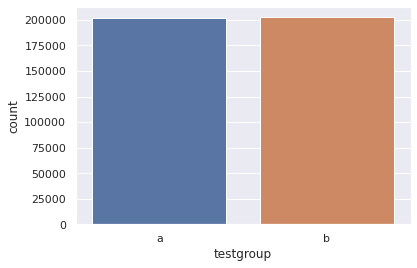

In [49]:
#  Посмотрим на количество пользователей в каждой из групп
sns.countplot(x='testgroup', 
              data=df,
              order=['a', 'b'])

График показывает, что количество пользователей в каждой из групп примерно одинаковое.

In [50]:
# Посмотрим на платящих игроков группы а
df.loc[(df.testgroup == 'a') & (df.revenue>0)]

,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a
416,417,37324,a
712,713,255,a
...,...,...,...
404304,404305,360,a
404315,404316,262,a
404543,404544,369,a
404602,404603,251,a


In [51]:
# Посмотрим на платящих игроков группы b
df.loc[(df.testgroup == 'b') & (df.revenue>0)]

,user_id,revenue,testgroup
160,161,3797,b
377,378,3768,b
386,387,3527,b
551,552,2038,b
913,914,3902,b
...,...,...,...
403843,403844,3383,b
403994,403995,2793,b
404161,404162,2316,b
404193,404194,2998,b


In [52]:
# Смотрим на условия задания и делаем вывод, что группа b является тестовой, а группа а - контрольной.
df_control = df.loc[df.testgroup == 'a']
df_test = df.loc[df.testgroup == 'b']

In [54]:
# Создадим столбец с фактом оплаты
df["pay"] = (df["revenue"] > 0).astype(int)
df

,user_id,revenue,testgroup,pay
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0
...,...,...,...,...
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0


In [55]:
# Для анализа связи между двумя категориальными переменными (группа и оплата) проведем тест хи-квадрат.
# Н0 - переменные группа и оплата независимы.
# Н1 - переменные группа и оплата зависимы.
stat, p, dof, expected = chi2_contingency (pd.crosstab(df.testgroup, df.pay))

In [56]:
stat, p

(4.374729521260405, 0.03647561892312613)

Показатель p-value=0.036, что меньше 0.05, то мы можем отвергнуть нулевую гипотезу. Существует статистически значимая связь между группой и платящим пользователем.

Посмотрим на гистограмму распределения значений выручки для обоих групп

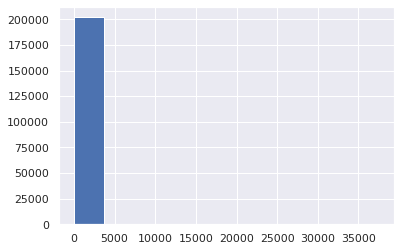

In [58]:
# Для группы a
df_control.revenue.hist()

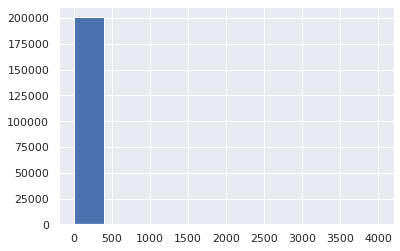

In [59]:
# Для группы b
df_test.revenue.hist()

Из гистограмм ясно, что в контрольной группе существуют сильные выбросы.

Посмотрим подробно на нее.

In [60]:
df_control.revenue.value_counts()

0        200175
206          18
310          18
265          17
224          17
          ...  
37379         1
37341         1
37347         1
37407         1
37357         1
Name: revenue, Length: 269, dtype: int64

In [61]:
df_control.revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

Значение 0 очень распространено в группе. Также существуют выбросы очень больших значений.
Посмотрим на распределения без нулевых значений.

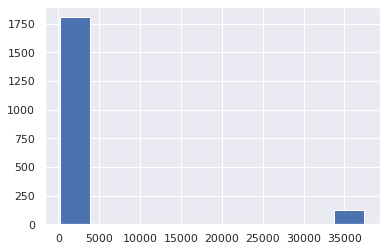

In [62]:
df_control[(df_control.revenue > 0)].revenue.hist()

In [63]:
df_control[(df_control.revenue > 0)].revenue.value_counts()

310      18
206      18
397      17
265      17
224      17
         ..
37341     1
37342     1
37344     1
37345     1
37433     1
Name: revenue, Length: 268, dtype: int64

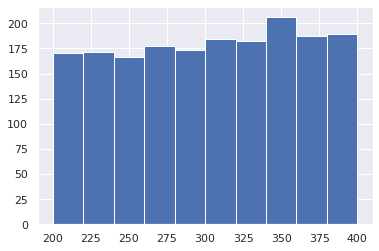

In [64]:
# Рассмотрим распределение значений в контрольной группе в промежутке от 0 до 1000
df_control[(df_control.revenue > 0)& (df_control.revenue < 1000)].revenue.hist()

In [65]:
df_control[(df_control.revenue > 0)& (df_control.revenue < 1000)].revenue.value_counts()

206    18
310    18
397    17
265    17
224    17
       ..
395     4
245     2
392     2
330     2
225     2
Name: revenue, Length: 201, dtype: int64

In [66]:
df_control[(df_control.revenue > 0)& (df_control.revenue < 1000)].revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

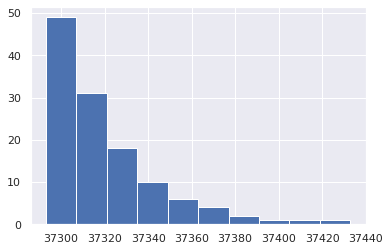

In [67]:
# Рассмотрим распределение значений в контрольной группе больше 1000
df_control[(df_control.revenue >= 1000)].revenue.hist()

In [68]:
df_control[(df_control.revenue >= 1000)].revenue.value_counts()

37295    5
37302    4
37294    4
37296    4
37297    4
        ..
37328    1
37327    1
37325    1
37324    1
37379    1
Name: revenue, Length: 67, dtype: int64

In [69]:
df_control[(df_control.revenue >= 1000)].revenue.describe()

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

В контрольной группе - 123 выброса (значения в диапазоне 37293 - 37433).
1805 значения в диапазоне 200 - 400.
Остальные 0 - 200175.
(Проверка: Скалдываем все- получаем 202103 игроков , как и по тексту задания).

In [70]:
123/1928*100

6.379668049792531

6.38% - доля выбросов (с выручкой больше 37000) в совокупности платящих игроков.

In [71]:
df_control[(df_control.revenue >= 1000)].revenue.sum() / df_control.revenue.sum() *100

89.37077665950378

Выручка от выбросов (с выручкой больше 37000) составляет 89% от общей.

Смотрим группу b.

In [73]:
df_test.revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [74]:
df_test.revenue.value_counts()

0       200862
2003         6
3359         5
3367         4
3410         4
         ...  
3150         1
3022         1
2894         1
3535         1
2114         1
Name: revenue, Length: 1209, dtype: int64

Значение 0 также очень распространено в тестовой группе. Посмотрим на распределения без нулевых значений.

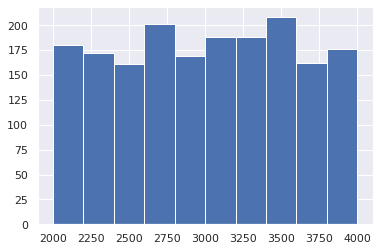

In [75]:
df_test[(df_test.revenue > 0)].revenue.hist()

In [76]:
df_test[(df_test.revenue > 0)].revenue.value_counts()

2003    6
3359    5
2709    4
2903    4
2225    4
       ..
3197    1
3196    1
3186    1
3185    1
2051    1
Name: revenue, Length: 1208, dtype: int64

In [77]:
df_test[(df_test.revenue > 0)].revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

В тестовой группе 1805 значения в диапазоне 2000 - 4000.
Остальные 0 - 200862.
(Проверка: Скалдываем все- получаем 202667 игроков , как и по тексту задания).

Посмотрим, что покажет тест Шапиро-Уилко на нормальность распределений выручки в группах

In [78]:
ss.shapiro(df_control['revenue'])

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)

In [79]:
ss.shapiro(df_control.query('revenue != 0')['revenue'])

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [80]:
ss.shapiro(df_control.query('revenue != 0 & revenue < 1000')['revenue'])

ShapiroResult(statistic=0.9546283483505249, pvalue=3.004845972000649e-23)

In [81]:
ss.shapiro(df_test['revenue'])

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)

In [82]:
ss.shapiro(df_test.query('revenue != 0')['revenue'])

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

Так как P-значение или равно 0, или имеет очень маленькое значение, это значит, что распределения выручки обоих выборок не являются нормальными.

In [83]:
# Проверим требование к гомогенности дисперсий
levene(df_control['revenue'], df_test['revenue'])

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

P-значение равно 0.5325. Это означает, что нет статистически значимых различий в дисперсиях между группами.

### Посмотрим на важные метрик в разрезе каждой группы.
#### Начнем с ARPU (average revenue per user), так как в тексте задания дана разница по группам.
Общий доход / Количество пользователей за период

In [84]:
# Посчитаем для контрольной группы
arpu_control = round(df_control['revenue'].sum() / df_control['user_id'].nunique(), 2)
arpu_control

25.41

In [85]:
# Посчитаем для тестововой группы
arpu_test = round(df_test['revenue'].sum() / df_test['user_id'].nunique(), 2)
arpu_test

26.75

In [86]:
# Сверимся с условиями задания, в соответствии с которыми ARPU в тестовой группе выше на 5%, чем в контрольной
round (((arpu_test - arpu_control)/ arpu_test)*100)

5

Для интереса посчитаем метрику для ситуации , когда из контрольной группы исключили выбросы.

In [87]:
# Посчитаем для контрольной группы без выбросов
arpu_control_no37 = round(df_control.loc[(df_control['revenue'] < 37000)]['revenue'].sum() \
                         / df_control.loc[(df_control['revenue'] < 37000)]['user_id'].nunique(), 2)
arpu_control_no37

2.7

Как мы видим,есть большой разрыв между ARPU контрольной группы и ARPU контрольной группы без выбросов.

#### ARPPU (Average Revenue Per Paying User) 
Общий доход за период / Количество платящих пользователей за период

In [88]:
arppu_contol = round(df_control['revenue'].sum() / df_control.query('revenue != 0')['user_id'].nunique(), 2)
arppu_contol

2664.0

In [89]:
arppu_test = round(df_test['revenue'].sum() / df_test.query('revenue != 0')['user_id'].nunique(), 2)
arppu_test

3003.66

In [90]:
round(((arppu_test - arppu_contol) / arppu_test * 100), 2)

11.31

ARPPU тестовой группы больше контрольной на 11.31%

Для интереса посчитаем метрику для ситуации , когда из контрольной группы исключили выбросы.

In [91]:
arppu_control_no37 = round(df_control.loc[(df_control['revenue'] < 37000)]['revenue'].sum() \
                        / df_control.loc[(df_control['revenue'] < 37000) & (df_control['revenue'] != 0)]['user_id'].nunique(), 2)
arppu_control_no37

302.46

Как мы видим,есть большой разрыв между ARPU контрольной группы и ARPPU контрольной группы без выбросов.

### Посчитаем CR
CR = Число платящих игроков / Общее кол-во игроков × 100%

In [92]:
#Для контрольной группы
cr_control = round(df_control.loc[(df_control.revenue>0)].user_id.nunique() / df_control.user_id.nunique() * 100, 2)
cr_control

0.95

In [93]:
cr_test = round(df_test.loc[(df_test.revenue>0)].user_id.nunique() / df_test.user_id.nunique() * 100, 2)
cr_test

0.89

Конверсия в контрольной группе больше, чем в тестовой.
Мы уже провели стат тест на CR, у которого p-value < 0.05, что говорит о том, что количество платящих пользователей в Контрольной группе статистически больше, чем в тестовой по тесту хи-квадрат. При этом количество клиентов в обеих группах примерно на одном уровне. 


Для интереса посчитаем метрику для ситуации , когда из контрольной группы исключили выбросы.

In [94]:
#Для контрольной группы без выбросов
cr_control_no37 = round(df_control.loc[(df_control.revenue>0) & (df_control['revenue'] < 37000)].user_id.nunique() \
                      / df_control.loc[(df_control['revenue'] < 37000)].user_id.nunique() * 100, 2)
cr_control_no37

0.89

Как мы видим,есть разница между ARPU контрольной группы и ARPPU контрольной группы без выбросов.

Мы приходим к следующим результатам: 

revenue в обеих группах распределены ненормально, 
между метриками есть различия. 
Плюс в контрольной группе есть выбросы, что ограничивает в выборе статистического метода исследования.
При этом предполагаю, что не учитывать их нельзя, так как могут быть полученны неверные результаты. Поэтому будем использовать  исходные данные (с выбросами).

Для анализа ARPU и ARPPU этих групп можно использовать непараметрические статистические методы, такие как тест Манна-Уитни или bootstrap. В связи с тем что результаты U-теста сложно интерперетировать, будем использовать bootstrap.

Возьмем код функции из прикрепленного ноутбука к видео А.Карпова про этот тест на Ютьюбе. 

In [95]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return { "quants": quants, 
            "p_value": p_value}

Начнем с ARPU.

Гипотезы:

H0 - среднее значение выручки пользователя в группах не отличается.

Н1 - среднее значение выручки пользователя в группах отличается. 

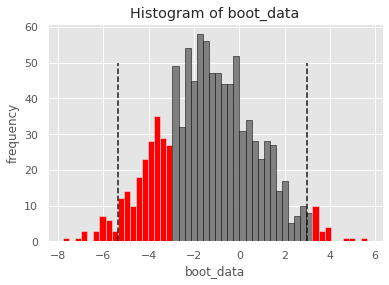

{'quants':               0
 0.025 -5.341847
 0.975  2.999868,
 'p_value': 0.5275270835846052}

In [97]:
get_bootstrap(df_control['revenue'], df_test['revenue'])


Когда результаты теста bootstrap показывают p-значение равное 0.528, это означает, что нет статистически значимых различий между переменными, которые были сравнены с использованием bootstrap метода.
В случае метрики ARPU (Average Revenue Per User), если нулевое значение лежит в доверительном интервале, это означает, что нет статистически значимых различий в доходе на пользователя между группами. 
Мы не можем отклонить нулевую гипотезу о равенстве групп. Это означает, что на основе проведенного bootstrap анализа мы не можем сделать вывод о статистически значимых различиях между группами или переменными.
В этом случае можно сделать вывод, что различия в ARPU между группами не являются статистически значимыми.

ARPPU 
Гипотезы:

H0 - среднее значение выручки платящего пользователя в группах не отличается.

Н1 - среднее значение выручки платящего пользователя в группах отличается.

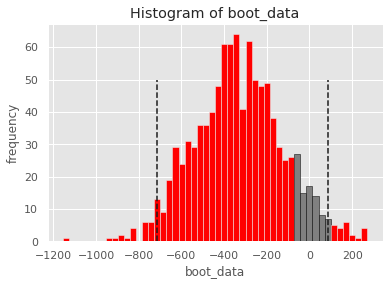

{'quants':                 0
 0.025 -716.489367
 0.975   85.568659,
 'p_value': 0.10888851715916793}

In [98]:
get_bootstrap(df_control.loc[df_control['revenue'] > 0]['revenue'], df_test.loc[df_test['revenue'] > 0]['revenue'])

Когда результаты теста bootstrap показывают p-значение равное 0.11, это означает, что нет статистически значимых различий между переменными, которые были сравнены с использованием bootstrap метода. В случае метрики ARPPU (Average Revenue Per Paying User) , если нулевое значение лежит в доверительном интервале, это означает, что нет статистически значимых различий в доходе на пользователя между группами. Мы не можем отклонить нулевую гипотезу о равенстве групп. Это означает, что на основе проведенного bootstrap анализа мы не можем сделать вывод о статистически значимых различиях между группами или переменными. 

Несмотря на то, что было принято решение рассматривать контрольную выборку вместе с выбросами, ради интереса попробуем отбросить их из нее и провести бутстрап анализ для обоих показателей.

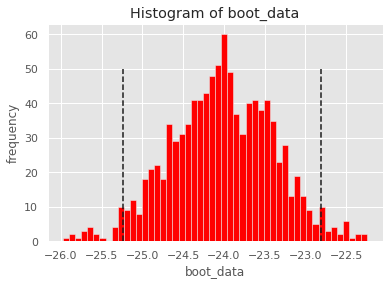

{'quants':                0
 0.025 -25.235828
 0.975 -22.809934,
 'p_value': 0.0}

In [99]:
get_bootstrap(df_control.loc[(df_control['revenue'] < 37000)]['revenue'], df_test['revenue'])

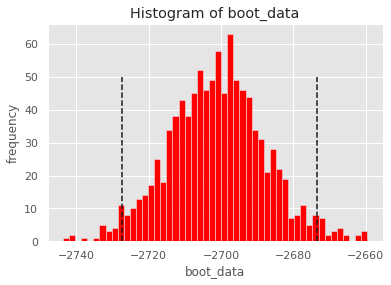

{'quants':                  0
 0.025 -2727.395970
 0.975 -2673.561731,
 'p_value': 0.0}

In [100]:
get_bootstrap(df_control.loc[(df_control['revenue'] > 0) & (df_control['revenue'] < 37000), 'revenue'], df_test.loc[df_test['revenue'] > 0, 'revenue'])

Интересно, что без учета выбросов в контрольной группе мы получаем такие показатели (р-value), которые позволяют сделать вывод, что нулевая гипотеза о равенстве средних значений ARPU и ARPPU выборок отвергается на уровне значимости, равном 0. Таким образом, можно сделать вывод о статистически значимых различиях между выборками по показателям revenue после исключения выбросов из контрольной выборки.
Эти результаты говорят о том, что исключение выбросов из контрольной выборки может существенно повлиять на результаты анализа и интерпретацию различий между выборками. В данном случае, статистически значимые различия между контрольной и тестовой выборками по показателям ARPU и ARPPU подтверждаются после исключения выбросов из контрольной выборки.

### По итогам проведенного анализа можно сделать следующие выводы:
#### С самого начала отметим, что на 6.38 %  от платящих пользователей (123 клиента) контрольной группы приходится 89% выручки от всех платящих пользователей этой группы. Нужно понять природу данных выбросов: это ошибка А/В теста или это реальные платящие игроки, или это выброс. 
#### В связи с тем что мы не имеем необходимой достатоной информации, отбрасывать данные выбросы считаю неправильным. Это может повлиять на результаты теста неправильным образом.
#### По итогам проведенного bootstrap различия в ARPU и ARPPU между группами не являются статистически значимыми. При этом метрики в тестовой группе  выше, а в контрольной группе конверсия статистически выше.

#### Мы все же провели анализ контрольной группы без учета выбросов, по результатам которого напрашивается вывод о статистически значимых различиях между выборками по показателям revenue после исключения выбросов из контрольной выборки. Разница в метриках тестовой и контрольной без выбросов группах в абсолютном значении стала еще более разительной. 

#### Делаем вывод, для начала нужно предварительно убедиться в точности А/Б теста, проверить, что данные были собраны без ошибок. Изначально мы отталкиваемся от того, что прежде чем исключать выбросы, обязательно нужно понять их природу, необходимо провести дополнительный анализ ,  прежде чем принимать решение о (не)распространении акции на всех пользователей.

### Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

 

####  Предлагаю следующие метрики для оценки результатов последнего прошедшего события:
1. Количество полученных уникальных предметов, монет или бонусов.
2. DAU (Daily Active Users) - процент активных пользователей, участвовавших в событии. Характеризует активность игроков. 
3. ARPU (Average Revenue Per User) - средний доход с привлечённого пользователя. Отслеживает монетизацию данного события.
4. Средняя продолжительность сессии - показывает, сколько времени в среднем игроки тратили на событие.
5. RR (Retention Rate) - эта метрика оценивает, как событие удерживает игроков в игре после его завершения. Чем выше метрика, тем привлекательнее было событие для игроков.
6. CR (Conversion Rate)- процент игроков, которые завершили все требуемые уровни события и получили награду. Чем выше метрика, тем привлекательнее было событие для игроков.
7. Количество положительных отзывов - эта метрика показывает степень удовлетворенности игроков событием.

#### При усложнении механики событий с откатом при неудачной попытке на несколько уровней назад, можно использовать дополнительно следующие метрики, которые помогут оценить влияние усложнения на поведение игроков и их результаты:
1. Воронка событий - позволяет отследить шаги, которые игроки проходят от начального уровня до финального, и определить процент игроков, которые завершают каждый шаг.
2. Среднее количество попыток, требуемых для завершения уровня, - если много попыток, то можно сделать вывод о чрезмерной сложности события.
3. Среднее количество откатов, сделанных игроками во время события, - если много откатов, то можно сделать вывод о чрезмерной сложности события.

Предполагаю, что, вероятнее всего, усложнение механики событий с откатом при неудачной попытке на несколько уровней назад негативно скажется на удовлетворенности игроков.